## Imports

In [ ]:
from valorant import DATA_PATH

from glob import glob
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt, dates as mdates
import seaborn as sns
import plotly.express as px

plt.style.use('ggplot')
pd.options.display.max_columns = 500
pd.options.display.max_rows = 20

# Valorant Esports EDA

The Purpose of the notebook is to explore data related to the Valorant Esports Scene: Valorant Champion Tourm 2021-2023

Data is courtesy of Ryan Luong who webscraped from vlr.gg. I downloaded the data as of 2024-02-23.
<br>https://www.kaggle.com/datasets/ryanluong1/valorant-champion-tour-2021-2023-data</br>

<b>Scope</b>

    - Explore and clean datasets
    - Define features
    - Define relationships
    - Explore case studies for projects

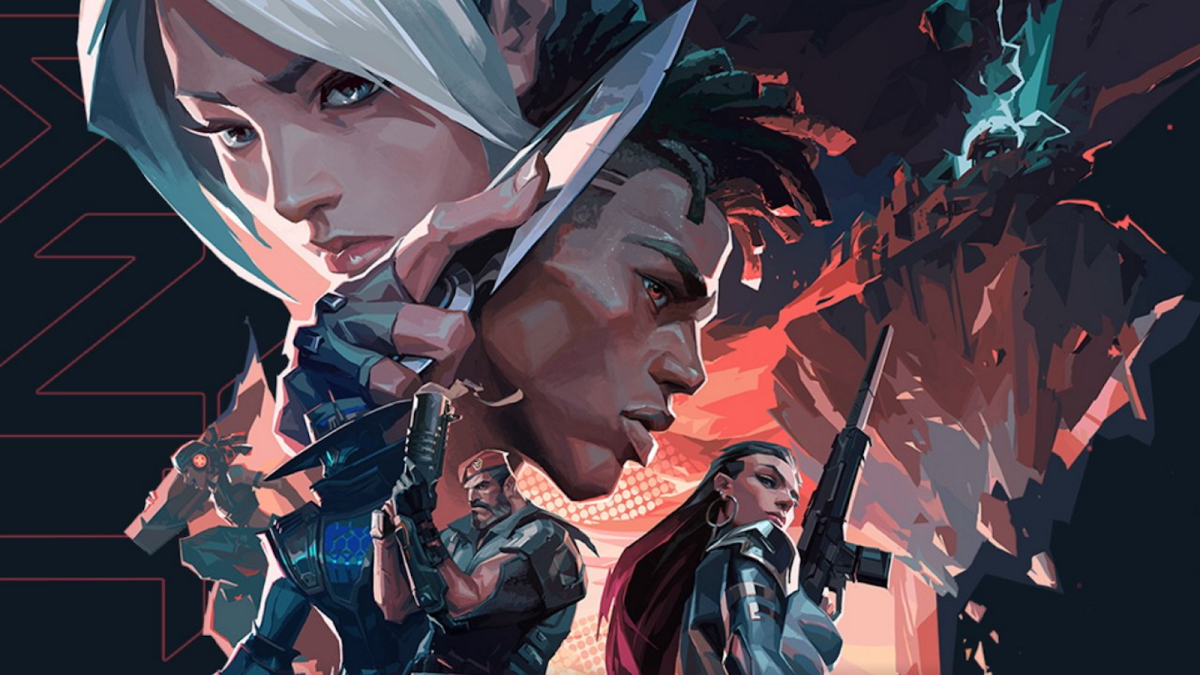

## Read data

The dataset includes matches, agents, and player data from VCT 2021–2023. This was obtained via data scraping at vlr.gg. Each year contains three folders: agents, matches, player stats, and IDs.

The agents folder contains agent pick rates, map pick rates, attacker and defender side win/loss percentage, team pick rates on an agent, and win/loss rate.

The matches folder contains team picks and bans, their economy on each round of a match, their economy stats on a match, players kills performance on other players, players kill stats, maps that were played on a match, the scores from the map, players overview stats, a player kills performance on players and their agent on a specific round, matches scores and their results, and a list of abbreviated team names with their full names.

The player stats folder only contains player stats.

The ids folder contains the ids for the teams, players, tournaments, stages, match types, matches, and games.

The all_values folder contains all the agent combinations played, the IDs, and the abbreviated team name with their full name.

In [ ]:
# Define Paths
ALL_VALUES_PATH = f"{DATA_PATH}all_values"

VCT_2021_PATH = f"{DATA_PATH}vct_2021"
VCT_2022_PATH = f"{DATA_PATH}vct_2022"
VCT_2023_PATH = f"{DATA_PATH}vct_2023"

In [ ]:
# Read all files in directory specifed
files = glob(f'{VCT_2023_PATH}/*/*.csv')

dfs = []
for csv in files:
    df = pd.read_csv(csv)
    # Replace spaces with underscores and convert to uppercase
    df.columns = [col.replace(' ', '_').replace(',', '').replace('-', 'AND').upper() for col in df.columns]
    percent_cols = [col for col in df.columns if '%' in col]
    df[percent_cols] = df[percent_cols].apply(lambda x: x.str.rstrip('%').astype(float) / 100)

    dfs.append(df)

- Given the large amount of datasets I will focus and clean as I go. 
- Also going to focus on one year to keep it simple

In [ ]:
# Assigning tables to names
# Agents
agent_pick_rate = dfs[0]
map_stats = dfs[1]
team_agents = dfs[2]

# Ids
player_ids = dfs[3]
team_ids = dfs[4]
stage_match_type_ids = dfs[5]
stage_match_ids = dfs[6]

# Matches
draft_phase = dfs[7]
eco_rounds = dfs[8]
eco_stats = dfs[9]
kill_stats = dfs[10]
kills = dfs[11]
maps_played = dfs[12]
map_scores = dfs[13]
overview = dfs[14]
round_kills = dfs[15]
scores = dfs[16]
team_mapping = dfs[17]

# Players
player_stats = dfs[18]

In [ ]:
# Additional Tables I want
team_mapping

## Cleaning

- Aiming to combine some of the datasets into something a bit more usable

    DataFrame Ideas
    - Team + Players
    - Maps
    - Matches
    - Rounds

### Teams

In [ ]:
team_ids.head()

In [ ]:
player_ids.head()

In [ ]:
team_mapping.head()

In [ ]:
overview.head()

In [ ]:
overview.TOURNAMENT.nunique()

In [ ]:
overview.set_index([''])

In [ ]:
# Combine to get master team and player table
df_teams = pd.merge(team_mapping, 
                    pd.merge(player_ids, 
                             pd.merge(team_ids, 
                                      overview, 
                                      how='inner', 
                                      on='TEAM'), 
                             how='inner', 
                             on='PLAYER'), 
                    how='inner', 
                    left_on='FULL_NAME', 
                    right_on='TEAM')

df_teams = df_teams.drop(columns=['TOURNAMENT', 'STAGE', 'MAP', 'MATCH_TYPE', 'MATCH_NAME', 'AGENTS', 'SIDE'])

# Convert ids to strings
df_teams[['PLAYER_ID', 'TEAM_ID']] = df_teams[['PLAYER_ID', 'TEAM_ID']].astype(str)

# Take player stats for the year 2023 and aggregate by mean f:.2
int_cols = df_teams.select_dtypes(include=['float', 'int'])
stat_mean_values = df_teams.groupby('PLAYER_ID')[int_cols.columns].std().round(2)
stat_mean_values = stat_mean_values.add_prefix('MEAN_').reset_index()
df_teams = df_teams.drop(columns=int_cols)

# Merge the two dataframes to give our team and player table
df_teams = pd.merge(df_teams, stat_mean_values, how='inner', on='PLAYER_ID').drop_duplicates()
df_teams.head()

In [ ]:
df_teams.describe().T.style.background_gradient(cmap='magma')

In [ ]:
# Function to create plotly.express bar chart
def plotting_features(data, x, y, hue, title, xtitle, ytitle, legtitle):
    chart = px.bar(data, x=x, y=y, color=hue)
    chart.update_layout(
        title=title,
        xaxis_title=xtitle,
        yaxis_title=ytitle,
        legend_title=legtitle,
    )
    chart.show()

In [ ]:
# # Plotting players mean avg combat score
plotting_features(data=df_teams,
                    x='PLAYER',
                    y='MEAN_AVERAGE_COMBAT_SCORE',
                    hue='TEAM', 
                    title="Player's Mean Avg Combat score", 
                    xtitle='Player',
                    ytitle='Mean Avg Combat Score',
                    legtitle='Teams')

In [ ]:
# Plotting players headshot % ratio
plotting_features(data=df_teams,
                    x='PLAYER',
                    y='MEAN_HEADSHOT_%',
                    hue='TEAM', 
                    title="Player's Mean Avg Headshot Percentage", 
                    xtitle='Player',
                    ytitle='Headshot %',
                    legtitle='Teams')

## Explore features

## Explore relationships

## Case Studies